<a href="https://colab.research.google.com/github/CadeHarger/portfolio/blob/main/Personal_Projects/ChessAI_Round_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install python-chess==0.31.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 134 kB 5.1 MB/s 


In [ ]:
#@title Run on TensorFlow 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
%tensorflow_version 2.x


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
#@title Import Relevant Modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import chess
import chess.engine
import chess.svg
import chess.pgn
import random
import time

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [ ]:
#@title Feature Creation

numFeats = 14
movesPerGame = 2

squares_index = {
  'a': 0,
  'b': 1,
  'c': 2,
  'd': 3,
  'e': 4,
  'f': 5,
  'g': 6,
  'h': 7
}
'''
# ex: h3 -> 17
def square_to_index(square):
  letter = chess.square_name(square)
  return 8 - int(letter[1]), squares_index[letter[0]]
'''

def comprehendBoard(board):
  board3d = np.zeros((numFeats, 8, 8), dtype=np.int8)

  # get the available moves for each side (REDUNDANT)
  '''
  aux = board.turn
  board.turn = chess.WHITE
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[12][i][j] = 1
  board.turn = chess.BLACK
  for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      board3d[13][i][j] = 1
  board.turn = aux
  '''

  # get the location of each piece
  for piece in chess.PIECE_TYPES:
    for square in board.pieces(piece, chess.WHITE):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece - 1][7 - idx[0]][idx[1]] = 1
    for square in board.pieces(piece, chess.BLACK):
      idx = np.unravel_index(square, (8, 8))
      board3d[piece + 5][7 - idx[0]][idx[1]] = 1
  # get the number of attackers on each square for each side

  for square in chess.SQUARES:
    idx = np.unravel_index(square, (8, 8))
    board3d[12][idx[0]][idx[1]] = len(board.attackers(chess.WHITE, square))
  for square in chess.SQUARES:
    idx = np.unravel_index(square, (8, 8))
    board3d[13][idx[0]][idx[1]] = len(board.attackers(chess.BLACK, square))

  return board3d

In [ ]:
#@title Load the Dataset
trainData = pd.read_csv("ChessGames.csv")
trainData = trainData.to_numpy()
np.random.shuffle(trainData)
print(len(trainData))

# Create features/labels from dataset
betaFeatureSet = np.zeros((len(trainData) * movesPerGame, numFeats, 8, 8), dtype=np.int8)
betaLabelSet = np.zeros((len(trainData) * movesPerGame, 2), dtype=np.float16)
for x in range(len(trainData)):
  moves = trainData[x][3].split()
  for y in range(movesPerGame):
    board = chess.Board()
    randomMove = random.randrange(5, len(moves))
    for i in range(randomMove):
      board.push(board.parse_san(moves[i]))
    betaLabelSet[(x * movesPerGame) + y][0] = trainData[x][1] * -0.5 + 0.5 # One-hot encode -1, 0, 1 values
    betaLabelSet[(x * movesPerGame) + y][1] = trainData[x][1] * 0.5 + 0.5
    betaFeatureSet[(x * movesPerGame) + y] = comprehendBoard(board)

del trainData

print(len(betaFeatureSet))
print(len(betaLabelSet))

print(np.histogram(betaLabelSet, bins=2))

In [ ]:
#@title Mount Google Drive
import os
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
#@title Load the Dataset from Drive

minLength = 6

tic = time.perf_counter()
games = []
path = "/gdrive/MyDrive/AI Stuff/Chess/"
for filename in os.listdir(path):
  print(filename)
  if filename.endswith("txt"):
    with open(path + filename, 'r', encoding='latin-1') as file:
      parsing = False
      san = ""
      for i, line in enumerate(file):
        if parsing:
          if line == '\n':
            parsing = False
            moves = san.split()
            if len(moves) > minLength:
              games.append(moves)
            san = ""
          else:
            san += line
        elif line[0] == '1':
          parsing = True
          san += line
      print(i)
print(len(games))
toc = time.perf_counter()
print(f'Time: {toc - tic} seconds')

featureSetX = np.zeros((len(games) * movesPerGame, numFeats, 8, 8), dtype=np.int8)
labelSetX = np.zeros((len(games) * movesPerGame, 2), dtype=np.float16) # Black Score, White Score
for gameNo, game in enumerate(games):
  if gameNo % 30000 == 0:
    print(gameNo)
  for x in range(movesPerGame):
    board = chess.Board()
    randomMove = random.randrange(minLength, len(game) - 1)
    for i in range(randomMove):
      if '.' in game[i]:
        try:
          board.push(board.parse_san(game[i].split('.')[1]))
        except:
          print(game[i].split('.'), game)
          board.push('Rg1')
      else:
        board.push(board.parse_san(game[i]))
    index = gameNo * movesPerGame + x
    outcome = game[-1]
    featureSetX[index] = comprehendBoard(board)
    if outcome[0] == '1':
      if outcome[1] == '/':
        labelSetX[index][0] = 0.5
        labelSetX[index][1] = 0.5
      else:
        labelSetX[index][0] = 0
        labelSetX[index][1] = 1
    else:
      labelSetX[index][0] = 1
      labelSetX[index][1] = 0

del games

# Diagnostics
print(len(featureSetX))
print(len(labelSetX))

print(np.histogram(labelSetX, bins=2))
print(f'Time: {time.perf_counter() - toc} seconds')
print(np.shape(featureSetX))


In [ ]:
#@title Merging Datasets

testSize = 30000

featureSet = np.append(featureSetX, betaFeatureSet, axis=0)
labelSet = np.append(labelSetX, betaLabelSet, axis=0)
print(np.shape(featureSet))
print(np.shape(labelSet))

# Shuffle the features and labels together
shuffler = np.random.permutation(len(featureSet))
featureSet = featureSet[shuffler]
labelSet = labelSet[shuffler]

# Split the test and training datasets
testFeatureSet = featureSet[-1 * testSize:]
testLabelSet = labelSet[-1 * testSize:]
featureSet = featureSet[0:-1 * testSize]
labelSet = labelSet[0:-1 * testSize]

(554546, 14, 8, 8)
(554546, 2)


In [ ]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [ ]:
#@title Model Creation
def createModel(lr):
  kernelSize = (3,3)
  filters = 64
  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.InputLayer(input_shape=(numFeats, 8, 8)))

  model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernelSize, padding='same', activation='relu', input_shape=(numFeats, 8, 8), data_format='channels_first'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(rate=0.1))

  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

  model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernelSize, padding='same', activation='relu', data_format='channels_first'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(rate=0.1))

  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

  model.add(tf.keras.layers.Conv2D(filters=filters, kernel_size=kernelSize, padding='same', activation='relu', data_format='channels_first'))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dropout(rate=0.1))

  model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer='l2'))

  model.add(tf.keras.layers.Dropout(rate=0.1))

  model.add(tf.keras.layers.Dense(units=2, activation="softmax",
                                  name='Output'))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                loss="categorical_crossentropy",
                metrics=['accuracy'])


  return model

In [ ]:
#@title Model Training
def trainModel(model, features, label, epochs,
                batchSize=None, validationSplit=0.1):

  history = model.fit(x=features, y=label, batch_size=batchSize,
                      epochs=epochs, shuffle=True, validation_split=validationSplit)

  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 8, 8)          8128      
                                                                 
 batch_normalization (BatchN  (None, 64, 8, 8)         32        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64, 8, 8)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 4, 8)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 4, 8)          18496     
                                                                 
 batch_normalization_1 (Batc  (None, 64, 4, 8)         3

[0.6418625712394714, 0.5682333111763]

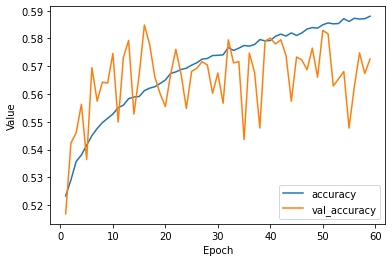

In [ ]:
#@title The AI

lr = 0.00008
epochs = 60
batchSize = 196
validationSplit = 0.2

model = createModel(lr)
model.summary()

epochs, hist = trainModel(model, featureSet, labelSet, epochs, batchSize, validationSplit)
metrics = ['accuracy', 'val_accuracy']
plot_curve(epochs, hist, metrics)

print("Evaluate Model on Test Set:")
model.evaluate(x = testFeatureSet, y = testLabelSet, batch_size=batchSize)

In [ ]:
#@title Generating AI Move

def getAIMove(board, movesAhead):
  tic = time.perf_counter()
  moveTree = generateMoveTree(board, movesAhead)
  treeGenTime += time.perf_counter() - tic
  print("Tree Generated")
  eval = minimax(moveTree, movesAhead * 2, -3, 3, board.turn)
  return moveTree.children[[move.score for move in moveTree.children].index(eval)].data.copy()

class Node():
  def __init__(self, data):
    self.data = data
    self.children = []
    self.score = 0.0
  def setChildren(self,obj):
    self.children = obj

# Generates a tree of possible moves with n ply
def generateMoveTree(move, n):
  children = [Node(move.data.copy()) for available in move.data.legal_moves]
  for i, available in enumerate(move.data.legal_moves):
    children[i].data.push(available)
  move.setChildren(children)
  if n - 1 != 0:
    for node in move.children:
      generateMoveTree(node, n - 1)

# Alpha = worst possible score for white assuming white plays logically
# Beta = the exact oppposite
# Best Black = -1, Best White = 1
def minimax(moveTree, depth, alpha, beta, isWhite):
  if moveTree.data.is_checkmate():
    return isWhite * 3 - 1
  if depth == 0:
    features = np.zeros((1, numFeats, 8, 8), dtype=np.int8)
    features[0] = comprehendBoard(moveTree.data)
    prediction = model.predict(features, verbose=False)
    moveTree.score = prediction[0][1] - prediction[0][0]
    return moveTree.score
  if isWhite:
    maximum = -1
    for node in moveTree.children:
      eval = minimax(node, depth - 1, alpha, beta, 0)
      maximum = max(maximum, eval)
      alpha = max(alpha, eval)
      if beta <= alpha:
        break
    moveTree.score = maximum
    return maximum
  else:
    minimum = 1
    for node in moveTree.children:
      eval = minimax(node, depth - 1, alpha, beta, 1)
      minimum = min(minimum, eval)
      beta = min(beta, eval)
      if beta <= alpha:
        break
    moveTree.score = minimum
    return minimum


In [ ]:
#@title Testing Play

def playerVsAI():
  board = chess.Board()
  moveCount = 0
  while True:
    if moveCount == 0:
      board.push(board.parse_san('e4'))
    elif moveCount == 1:
      board.push(board.parse_san('Nf3'))
    else:
      tic = time.perf_counter()
      newBoard = getAIMove(board)
      board.push(newBoard.move_stack[-1])
      print(f'Time: {time.perf_counter() - tic} seconds')
    print(f'\n{board}')
    if board.is_game_over():
        break
    while True:
      move = input("Enter a move: ")
      try:
        board.push_san(move)
        break
      except:
        print('Invalid move')
    if board.is_game_over():
        break
    moveCount += 1

def AIVsAI(board, movesAhead, variance):
  treeGenTime = 0
  minimaxTime = 0
  board.push(board.parse_san('e4'))
  board.push(board.parse_san('e5'))
  board.push(board.parse_san('Nf3'))
  board.push(board.parse_san('Nc6'))
  totalPly = movesAhead * 2
  while 1:
    tic = time.perf_counter()
    moveTree = Node(board)
    generateMoveTree(moveTree, totalPly)
    treeGenTime += time.perf_counter() - tic
    print("Tree Generated")
    toc = time.perf_counter()
    eval = minimax(moveTree, totalPly, -3, 3, board.turn)
    print(eval)
    minimaxTime += time.perf_counter() - toc

    if board.turn:
      scores = [move.score for move in moveTree.children]
    else:
      scores = [move.score * -1 + 1 for move in moveTree.children]
    index = np.argmax(np.add(scores, (np.random.rand(len(scores)) - 0.5) * np.std(scores) * 2 * variance))
    board.push(moveTree.children[index].data.move_stack[-1])
    print(f'Time: {time.perf_counter() - tic} seconds')
    print(f'\n{board}')
    if board.is_game_over():
      for move in moveTree.children:
        print(move.score)
        if move.score == 0.0:
          print(move.data)
      break
  print("Tree Generation Time: ", end="")
  print(treeGenTime)
  print("Average Tree Generation Time: ", end="")
  print(treeGenTime / len(board.move_stack))
  print("Total Minimax Time: ", end="")
  print(minimaxTime)
  print("Average Minimax Time: ", end="")
  print(minimaxTime / len(board.move_stack))

movesAhead = 1
variance = 1 # Number of standard deviations to modify the scores for each move by
board = chess.Board()
AIVsAI(board, movesAhead, variance)

board


In [ ]:
prev = 0
newBoard = chess.Board()

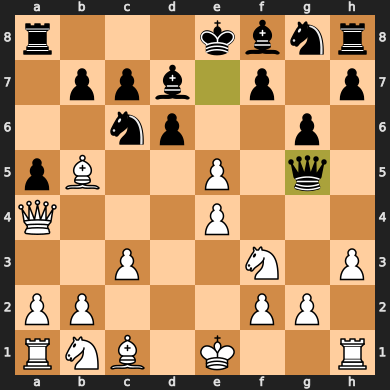

In [ ]:
newBoard.push(board.move_stack[prev])
prev += 1
newBoard

In [ ]:
#@title Reinforcement
#Try making output for draws [0.5-0.5]
#Add back attackers feature
#Add Hash Tables